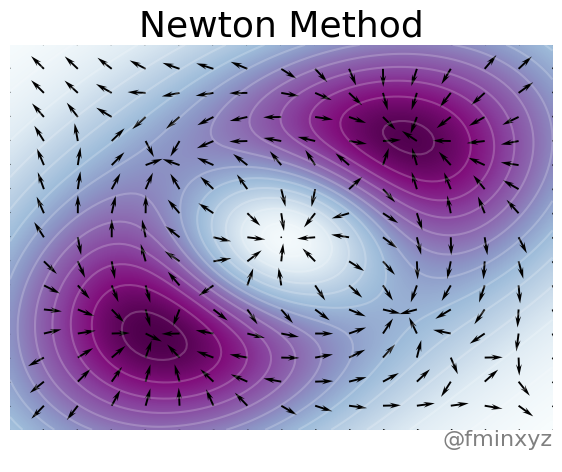

In [31]:
from jax import grad, vmap, hessian
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm

direction_type="Gradient Descent"
# direction_type="Ideal"
direction_type="Newton Method"

def rotate(x, y, theta):
    xr = x * jnp.cos(theta) - y * jnp.sin(theta)
    yr = x * jnp.sin(theta) + y * jnp.cos(theta)
    return xr, yr

def gaussian(x, y, x0, y0, sigma_x, sigma_y, theta=0):
    xr, yr = rotate(x - x0, y - y0, theta)
    return jnp.exp(-((xr**2) / (2 * sigma_x**2) + (yr**2) / (2 * sigma_y**2)))

def peaks(x, y):
    z1 = -gaussian(x, y, 0, 0, 1, 1)
    z2 = gaussian(x, y, -1, -1, 1.5, 2, theta=jnp.pi / 6)
    z3 = gaussian(x, y, 1, 1, 2, 1.5, theta=-jnp.pi / 4)
    return 1.5 * z1 + z2 + z3

def antigradient(x, y, f=peaks):
    gradient_function = grad(f, argnums=(0, 1))
    g_x, g_y = gradient_function(x, y)
    norm = jnp.sqrt(g_x**2 + g_y**2)
    return -g_x / norm, -g_y / norm

def ideal(x, y, f=peaks):
    norm = jnp.sqrt(x**2 + y**2)
    return -x / norm, -y / norm

def newton_difection(x, y, f=peaks):
    gradient_function = grad(peaks, argnums=(0, 1))
    hessian_function = hessian(peaks, argnums=(0, 1))
    grad_x, grad_y = gradient_function(x, y)
    ((h_xx, h_xy), (h_yx, h_yy)) = hessian_function(x, y)
    newton_direction_x = -1/(h_xx*h_yy - h_xy*h_yx)*(h_yy*grad_x - h_xy*grad_y)
    newton_direction_y = -1/(h_xx*h_yy - h_xy*h_yx)*(-h_yx*grad_x + h_xx*grad_y)
    norm = jnp.sqrt(newton_direction_x**2 + newton_direction_y**2)
    return newton_direction_x / norm, newton_direction_y / norm


def direction(x, y, direction_type=direction_type):
    if direction_type == "Gradient Descent":
        return antigradient(x, y, f=peaks)
    elif direction_type == "Ideal":
        return ideal(x, y, f=peaks)
    elif direction_type == "Newton Method":
        return newton_difection(x, y, f=peaks)

# Prepare the grid
x = jnp.linspace(-3, 3, 100)
y = jnp.linspace(-3, 3, 100)
X, Y = jnp.meshgrid(x, y)
Z = peaks(X, Y)

x_grad = jnp.linspace(x.min(), x.max(), 17)
y_grad = jnp.linspace(y.min(), y.max(), 17)
X_grad, Y_grad = jnp.meshgrid(x_grad, y_grad)

# Flatten the grid for vectorization
x_flat, y_flat = X_grad.flatten(), Y_grad.flatten()

# Compute the gradients for each point
gradients = vmap(direction)(x_flat, y_flat)

# Unpack the gradients
U, V = gradients[0], gradients[1]

# Reshape the gradients back to the grid shape
U = U.reshape(X_grad.shape)
V = V.reshape(Y_grad.shape)

# Identify and remove the quiver at (0, 0)
center_x = jnp.argmin(jnp.abs(x_grad))
center_y = jnp.argmin(jnp.abs(y_grad))
U = U.at[center_x, center_y].set(0)
V = V.at[center_x, center_y].set(0)

# Plot the contour and quivers
fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(Z, 
               interpolation='bilinear', 
               cmap=cm.BuPu, 
               extent=(x.min(), x.max(), y.min(), y.max()), 
               origin="lower", 
               aspect="auto")

contour = ax.contour(X, Y, Z, 
                     levels=15, 
                     colors="white", 
                     linestyles="solid", 
                     alpha=.2)

ax.quiver(X_grad, Y_grad, U, V, 
          color='black', 
          scale=30, 
          headwidth=3, 
          headlength=6)

plt.axis("off")
plt.title(direction_type, fontsize=26)
ax.annotate('@fminxyz',
                fontsize=16, c='grey', zorder=20,
                xy=(1, -0.01), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                ha='right', va='bottom')
plt.show()

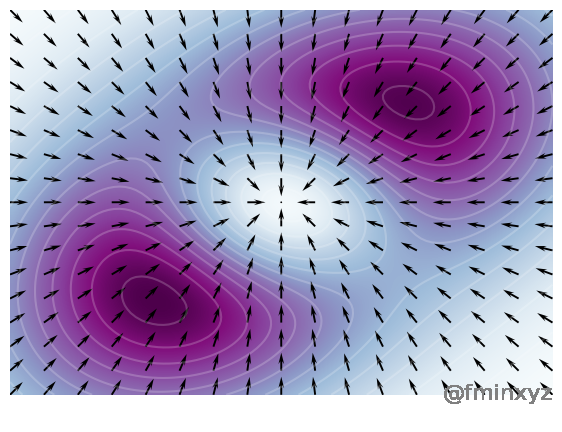

In [21]:
from jax import grad, vmap, hessian
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation

# Assume all your existing function definitions (rotate, gaussian, peaks, antigradient, ideal, newton_difection) are defined here.

# Modify the direction function to include all direction types and allow for interpolation
def direction(x, y, t, current_phase):
    if current_phase == "ideal":
        return ideal(x, y, f=peaks)
    elif current_phase == "gradient_descent":
        return antigradient(x, y, f=peaks)
    elif current_phase == "newton":
        return newton_difection(x, y, f=peaks)
    else:  # Handle interpolation based on the phase
        if current_phase == "ideal_to_gradient":
            dir1 = ideal(x, y, f=peaks)
            dir2 = antigradient(x, y, f=peaks)
        elif current_phase == "gradient_to_newton":
            dir1 = antigradient(x, y, f=peaks)
            dir2 = newton_difection(x, y, f=peaks)
        elif current_phase == "newton_to_ideal":
            dir1 = newton_difection(x, y, f=peaks)
            dir2 = ideal(x, y, f=peaks)

        interpolated_x = (1 - t) * dir1[0] + t * dir2[0]
        interpolated_y = (1 - t) * dir1[1] + t * dir2[1]
        norm = jnp.sqrt(interpolated_x**2 + interpolated_y**2)
        return interpolated_x/norm, interpolated_y/norm

# Prepare the grid
x = jnp.linspace(-3, 3, 100)
y = jnp.linspace(-3, 3, 100)
X, Y = jnp.meshgrid(x, y)
Z = peaks(X, Y)

x_grad = jnp.linspace(x.min(), x.max(), 17)
y_grad = jnp.linspace(y.min(), y.max(), 17)
X_grad, Y_grad = jnp.meshgrid(x_grad, y_grad)

fig, ax = plt.subplots(figsize=(7, 5))
im = ax.imshow(Z, interpolation='bilinear', cmap=cm.BuPu, extent=(x.min(), x.max(), y.min(), y.max()), origin="lower", aspect="auto")
contour = ax.contour(X, Y, Z, levels=15, colors="white", linestyles="solid", alpha=.2)
plt.axis("off")

quiver = None
fps = 60
segment_time = 5  # Duration of each segment in seconds
transition_frames = segment_time * fps
static_frames = segment_time * fps
total_frames = 6 * segment_time * fps  # Total number of frames for the entire sequence

# Phases order
phases = [
    ("ideal", static_frames), ("ideal_to_gradient", transition_frames),
    ("gradient_descent", static_frames), ("gradient_to_newton", transition_frames),
    ("newton", static_frames), ("newton_to_ideal", transition_frames)
]

titles = {
    "ideal": "Ideal",
    "ideal_to_gradient": "",
    "gradient_descent": "Gradient Descent",
    "gradient_to_newton": "",
    "newton": "Newton",
    "newton_to_ideal": ""
}

# Update function for the animation
def update(frame):
    global quiver
    current_phase_index = frame // (segment_time * fps)
    current_phase, phase_frames = phases[current_phase_index % len(phases)]
    frame_in_phase = frame % (segment_time * fps)
    t = frame_in_phase / phase_frames if "to" in current_phase else 0

    if quiver is not None:
        quiver.remove()

    # Compute directions for the current frame
    gradients = vmap(lambda x, y: direction(x, y, t, current_phase))(X_grad.flatten(), Y_grad.flatten())
    U, V = gradients[0].reshape(X_grad.shape), gradients[1].reshape(Y_grad.shape)

    center_x, center_y = jnp.argmin(jnp.abs(x_grad)), jnp.argmin(jnp.abs(y_grad))
    U = U.at[center_x, center_y].set(0)
    V = V.at[center_x, center_y].set(0)

    quiver = ax.quiver(X_grad, Y_grad, U, V, color='black', scale=30, headwidth=3, headlength=6)
    
    # Update title based on phase
    ax.set_title(titles[current_phase], fontsize=26)
    ax.annotate('@fminxyz',
                fontsize=16, c='grey', zorder=20,
                xy=(1, 0), xytext=(0, 20),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                ha='right', va='bottom')

    return quiver,

# Create the animation
anim = FuncAnimation(fig, update, frames=total_frames, interval=1000/fps, blit=True)
anim.save('Newton_convergence.mp4', dpi=400)

plt.show()